# US Traffic Accidents

## Overview

This project analyzes over 7 million U.S. traffic accident records to uncover how weather conditions, road features, and geography relate to accident severity. Key insights show that traffic-control infrastructure and seasonal patterns play a more significant role in accident outcomes than individual weather variables.

## Business Understanding

This analysis is based on a highly relevant and timely dataset that includes millions of real-world traffic accident records from across the United States. With growing concerns around traffic safety, infrastructure planning, and public health, the insights derived from this data have direct applications for real-world business and policy decisions. The size and detail of the dataset allow us to uncover patterns at both regional and city levels, making the findings actionable for city planners, transportation agencies, insurance providers, and public safety officials.

The project is driven by a few core analytical questions: What environmental and infrastructure-related factors are most strongly linked to accident severity? How do accident patterns shift across regions, temperature ranges, and different times of the year? Which road features present the greatest risk, and where should improvements be prioritized? These questions aim to deliver clear benefits like identifying high-risk zones, informing infrastructure upgrades, improving response planning during peak accident months, and guiding targeted safety campaigns. The main stakeholders in this analysis include state and local transportation departments, urban planners, traffic engineers, and public policy makers who are responsible for reducing traffic accidents and improving overall road safety.

## Data Understanding

In [2]:
# Load relevant imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import scipy.stats as stats

In [3]:
df = pd.read_csv('US_Accidents_March23.csv')

In [47]:
print(df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7541709 entries, 0 to 7541708
Data columns (total 57 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ID                        object        
 1   Source                    object        
 2   Severity                  int64         
 3   Start_Time                datetime64[ns]
 4   End_Time                  datetime64[ns]
 5   Start_Lat                 float64       
 6   Start_Lng                 float64       
 7   End_Lat                   float64       
 8   End_Lng                   float64       
 9   Distance(mi)              float64       
 10  Description               object        
 11  Street                    object        
 12  City                      object        
 13  County                    object        
 14  State                     object        
 15  Zipcode                   object        
 16  Country                   object        
 17  Timezone

In [9]:
# Get columns with missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Get data types
dtypes = df.dtypes

# Combine missing values and data types into a DataFrame
missing_df = pd.DataFrame({
    'Missing_Values': missing,
    'Data_Type': dtypes[missing.index]
})

print(missing_df)

                       Missing_Values Data_Type
End_Lat                       3402762   float64
End_Lng                       3402762   float64
Precipitation(in)             2203586   float64
Wind_Chill(F)                 1999019   float64
Wind_Speed(mph)                571233   float64
Visibility(mi)                 177098   float64
Wind_Direction                 175206    object
Humidity(%)                    174144   float64
Weather_Condition              173459    object
Temperature(F)                 163853   float64
Pressure(in)                   140679   float64
Weather_Timestamp              120228    object
Sunrise_Sunset                  23246    object
Civil_Twilight                  23246    object
Nautical_Twilight               23246    object
Astronomical_Twilight           23246    object
Airport_Code                    22635    object
Street                          10869    object
Timezone                         7808    object
Zipcode                          1915   

In [6]:
print(df.shape)

(7728394, 46)


## Data Preparation

In [ ]:
# Convert start and end time columns to datetime format to enable time-based analysis
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed')
df['End_Time'] = pd.to_datetime(df['End_Time'], format='mixed')

In [ ]:
# Extract year, month, day, and hour from the Start_Time column for temporal analysis
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Day'] = df['Start_Time'].dt.day
df['Hour'] = df['Start_Time'].dt.hour

In [10]:
# Fill missing End_Lat and End_Lng first
df['End_Lat'] = df['End_Lat'].fillna(df['Start_Lat'].round())
df['End_Lng'] = df['End_Lng'].fillna(df['Start_Lng'].round())

# Round to nearest whole number (0 decimal places)
df['Start_Lat'] = df['Start_Lat'].round()
df['Start_Lng'] = df['Start_Lng'].round()
df['End_Lat'] = df['End_Lat'].round()
df['End_Lng'] = df['End_Lng'].round()

In [11]:
# Drop rows where 'Weather_Condition' is missing
df = df[df['Weather_Condition'].notna()]
df = df[df['City'].notna()]

In [12]:
#Median Temperature by City + Month
city_month_temp = df.groupby(['City', 'Month'])['Temperature(F)'].median().reset_index()
city_month_temp.rename(columns={'Temperature(F)': 'CityMonth_Temp_Median'}, inplace=True)
df = df.merge(city_month_temp, on=['City', 'Month'], how='left')

#Fill using City + Month
df['Temperature(F)'] = df['Temperature(F)'].fillna(df['CityMonth_Temp_Median'])
df.drop(columns=['CityMonth_Temp_Median'], inplace=True)

#Median Temperature by State + Month (fallback)
state_month_temp = df.groupby(['State', 'Month'])['Temperature(F)'].median().reset_index()
state_month_temp.rename(columns={'Temperature(F)': 'StateMonth_Temp_Median'}, inplace=True)
df = df.merge(state_month_temp, on=['State', 'Month'], how='left')

#Fill using State + Month
df['Temperature(F)'] = df['Temperature(F)'].fillna(df['StateMonth_Temp_Median'])
df.drop(columns=['StateMonth_Temp_Median'], inplace=True)

# Filter to valid temperature range
df = df[(df['Temperature(F)'] >= -30) & (df['Temperature(F)'] <= 130)]


In [ ]:
#Main Median — City + Weather_Condition + Month
city_group = df.groupby(['City', 'Weather_Condition', 'Month'])['Precipitation(in)'].median().reset_index()
city_group.rename(columns={'Precipitation(in)': 'Median_City'}, inplace=True)
df = df.merge(city_group, on=['City', 'Weather_Condition', 'Month'], how='left')
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Median_City'])
df.drop(columns=['Median_City'], inplace=True)

#Fallback — State + Weather_Condition + Month
state_group = df.groupby(['State', 'Weather_Condition', 'Month'])['Precipitation(in)'].median().reset_index()
state_group.rename(columns={'Precipitation(in)': 'Median_State'}, inplace=True)
df = df.merge(state_group, on=['State', 'Weather_Condition', 'Month'], how='left')
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Median_State'])
df.drop(columns=['Median_State'], inplace=True)

# Remove rows where Precipitation(in) is missing to ensure data completeness for weather-related analysis
df = df[df['Precipitation(in)'].notna()]

In [15]:
# Select only object columns with missing values
object_cols_with_na = df.select_dtypes(include='object').columns
object_cols_with_na = [col for col in object_cols_with_na if df[col].isna().sum() > 0]

# Fill missing values with 'Unknown'
df[object_cols_with_na] = df[object_cols_with_na].fillna('Unknown')

In [ ]:
# Main Median — City + Weather_Condition + Month
humidity_city = df.groupby(['City', 'Weather_Condition', 'Month'])['Humidity(%)'].median().reset_index()
humidity_city.rename(columns={'Humidity(%)': 'Median_City_Humidity'}, inplace=True)

df = df.merge(humidity_city, on=['City', 'Weather_Condition', 'Month'], how='left')
df['Humidity(%)'] = df['Humidity(%)'].fillna(df['Median_City_Humidity'])
df.drop(columns=['Median_City_Humidity'], inplace=True)

# Fallback Median — State + Weather_Condition + Month
humidity_state = df.groupby(['State', 'Weather_Condition', 'Month'])['Humidity(%)'].median().reset_index()
humidity_state.rename(columns={'Humidity(%)': 'Median_State_Humidity'}, inplace=True)

df = df.merge(humidity_state, on=['State', 'Weather_Condition', 'Month'], how='left')
df['Humidity(%)'] = df['Humidity(%)'].fillna(df['Median_State_Humidity'])
df.drop(columns=['Median_State_Humidity'], inplace=True)

# Remove rows where Precipitation(in) is missing to ensure data completeness for weather-related analysis
df = df[df['Precipitation(in)'].notna()]

In [ ]:
# Drop Wind_Chill(F)
df.drop(columns=['Wind_Chill(F)'], inplace=True)

# List of columns to impute
cols_to_impute = ['Wind_Speed(mph)', 'Visibility(mi)', 'Pressure(in)']

for col in cols_to_impute:
    # 1. City + Weather + Month
    g1 = df.groupby(['City', 'Weather_Condition', 'Month'])[col].median().reset_index()
    g1.rename(columns={col: f'G1_{col}'}, inplace=True)
    df = df.merge(g1, on=['City', 'Weather_Condition', 'Month'], how='left')

    # 2. State + Weather + Month
    g2 = df.groupby(['State', 'Weather_Condition', 'Month'])[col].median().reset_index()
    g2.rename(columns={col: f'G2_{col}'}, inplace=True)
    df = df.merge(g2, on=['State', 'Weather_Condition', 'Month'], how='left')

    # Fill in order: G1 → G2 → global median
    global_med = df[col].median()
    df[col] = df[col].fillna(df[f'G1_{col}']) \
                     .fillna(df[f'G2_{col}']) \
                     .fillna(global_med)

    # Drop temp columns
    df.drop(columns=[f'G1_{col}', f'G2_{col}'], inplace=True)

# Drop rows where Wind Speed, Visibility, or Pressure values are missing to ensure completeness for weather-related analysis
df.dropna(subset=['Wind_Speed(mph)', 'Visibility(mi)', 'Pressure(in)'], inplace=True)

In [20]:
# Handle numeric columns with appropriate values
df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].fillna(df['Wind_Speed(mph)'].median())
df['Pressure(in)'] = df['Pressure(in)'].fillna(df['Pressure(in)'].median())
df['Weather_Timestamp'] = df['Weather_Timestamp'].fillna(df['Start_Time'])

# Handle categorical columns with string or mode
df['Wind_Direction'] = df['Wind_Direction'].fillna('Unknown')
df['Weather_Condition'] = df['Weather_Condition'].fillna('Unknown')
df['Airport_Code'] = df['Airport_Code'].fillna('Unknown')
df['Street'] = df['Street'].fillna('Unknown')
df['Zipcode'] = df['Zipcode'].fillna('Unknown')
df['City'] = df['City'].fillna('Unknown')
df['Description'] = df['Description'].fillna('Unknown')

# Fill twilight-related columns with mode
twilight_cols = ['Nautical_Twilight', 'Civil_Twilight', 'Sunrise_Sunset', 'Astronomical_Twilight']
for col in twilight_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [21]:
# Get min and max temps and floor/ceil to nearest 5
import numpy as np

min_temp = int(np.floor(df['Temperature(F)'].min() / 5) * 5)
max_temp = int(np.ceil(df['Temperature(F)'].max() / 5) * 5)

# Create even 5°F bins
bins = list(range(min_temp, max_temp + 5, 5))
labels = [f"{b}–{b+4}" for b in bins[:-1]]  # e.g., 35–39, 40–44

# Add bucket column
df['Temperature_Bucket'] = pd.cut(
    df['Temperature(F)'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False  # Make bins left-inclusive, right-exclusive
)


In [52]:
df.describe()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Year,Month,Day,Hour
count,7.541709e+06,7541709,7541709,7.541709e+06,7.541709e+06,7.541709e+06,7.541709e+06,7.541709e+06,7.541709e+06,7.541709e+06,7.541709e+06,7.541709e+06,7.541709e+06,7.541709e+06,7.541709e+06,7.541709e+06,7.541709e+06,7.541709e+06
mean,2.211022e+00,2020-06-05 13:34:36.052374784,2020-06-05 20:59:56.715745792,3.619989e+01,-9.468784e+01,3.620004e+01,-9.468759e+01,5.575025e-01,6.170093e+01,6.486065e+01,2.953843e+01,9.089684e+00,7.635955e+00,2.211152e-02,2.019912e+03,6.702179e+00,1.574449e+01,1.233298e+01
min,1.000000e+00,2016-01-14 20:18:33,2016-02-08 06:37:08,2.500000e+01,-1.250000e+02,2.500000e+01,-1.250000e+02,0.000000e+00,-3.000000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.016000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.000000e+00,2018-11-27 12:28:30,2018-11-27 13:58:00,3.300000e+01,-1.170000e+02,3.300000e+01,-1.170000e+02,0.000000e+00,4.900000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00,2.018000e+03,3.000000e+00,8.000000e+00,8.000000e+00
50%,2.000000e+00,2020-11-12 13:27:00,2020-11-12 18:45:40,3.600000e+01,-8.800000e+01,3.600000e+01,-8.800000e+01,2.900000e-02,6.400000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00,2.020000e+03,7.000000e+00,1.600000e+01,1.300000e+01
75%,2.000000e+00,2022-01-20 16:54:00,2022-01-21 09:45:49,4.000000e+01,-8.000000e+01,4.000000e+01,-8.000000e+01,4.600000e-01,7.600000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.000000e+01,0.000000e+00,2.022000e+03,1.000000e+01,2.300000e+01,1.700000e+01
max,4.000000e+00,2023-03-31 23:30:00,2023-03-31 23:59:00,4.900000e+01,-6.700000e+01,4.900000e+01,-6.700000e+01,4.417500e+02,1.292000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01,2.023000e+03,1.200000e+01,3.100000e+01,2.300000e+01
std,4.859421e-01,NaN,NaN,5.108773e+00,1.735635e+01,5.108744e+00,1.735651e+01,1.761658e+00,1.898122e+01,2.280133e+01,1.004115e+00,2.677529e+00,5.304069e+00,3.789014e-01,1.913292e+00,3.640575e+00,8.681458e+00,5.458285e+00


In [23]:
# Save the cleaned DataFrame to a new CSV file
df.to_csv('US_Accidents_Cleaned.csv', index=False)

### Exploratory Data Analysis

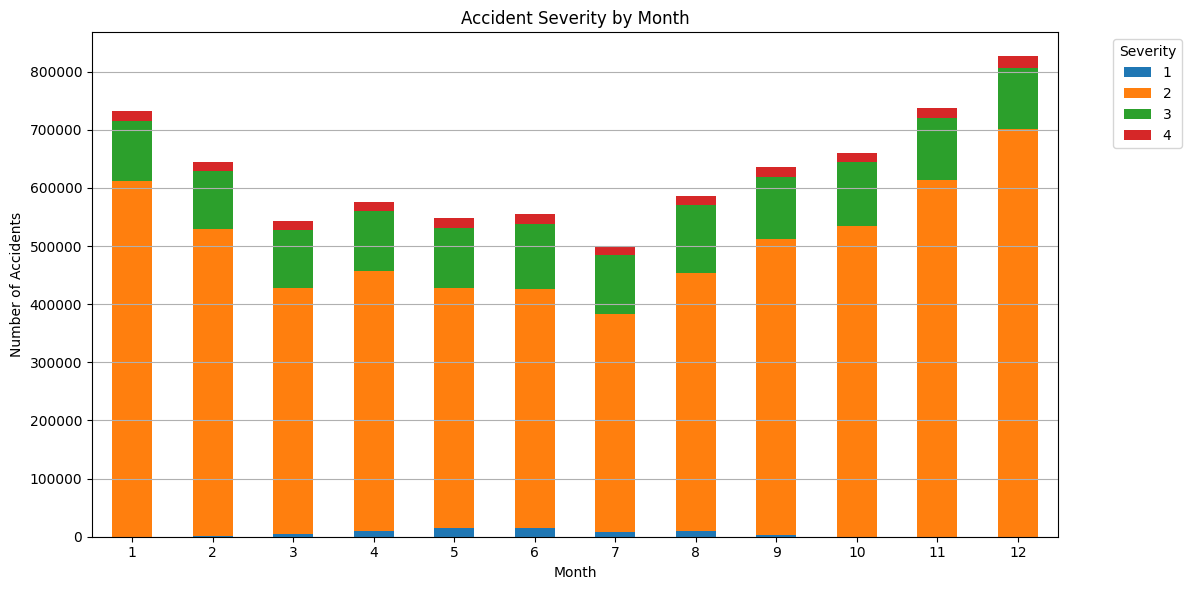

In [24]:
# Create crosstab of Month vs Severity
month_severity = pd.crosstab(df['Month'], df['Severity'])

# Sort by month number
month_severity = month_severity.sort_index()

# Plot stacked bar chart
month_severity.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Accident Severity by Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

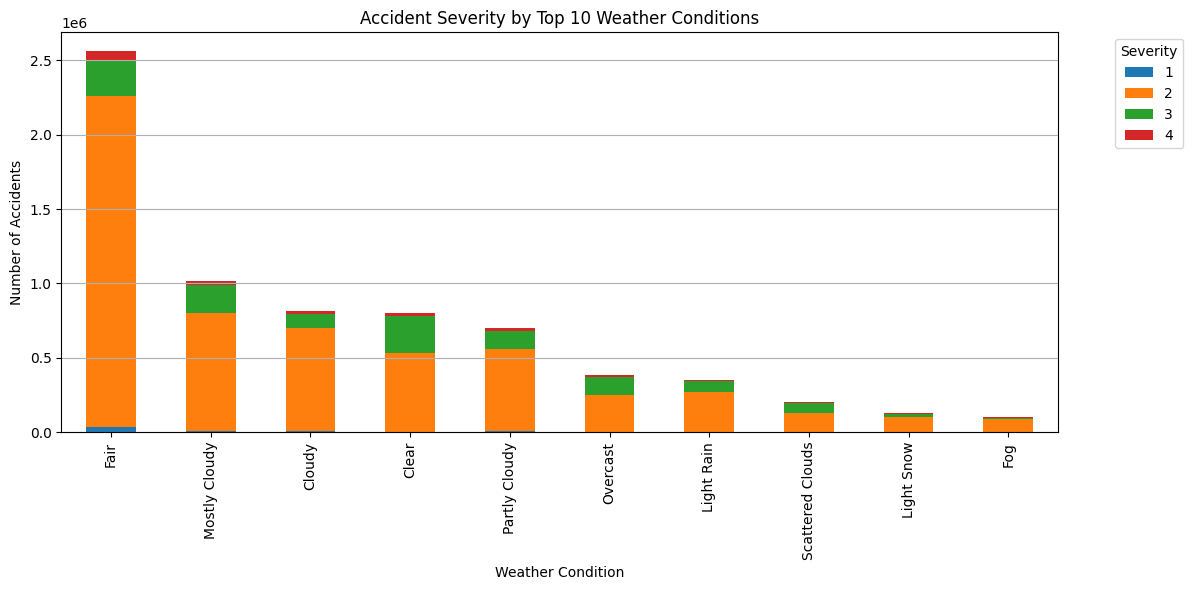

In [25]:
# Get the top 10 weather conditions by count
top_weather = df['Weather_Condition'].value_counts().head(10).index

# Filter the DataFrame
filtered_df = df[df['Weather_Condition'].isin(top_weather)]

# Create crosstab: Weather Condition vs Severity
weather_severity = pd.crosstab(filtered_df['Weather_Condition'], filtered_df['Severity'])

# Sort by total accidents (row sum) descending
weather_severity = weather_severity.loc[weather_severity.sum(axis=1).sort_values(ascending=False).index]

# Plot
weather_severity.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Accident Severity by Top 10 Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

<Figure size 1400x700 with 0 Axes>

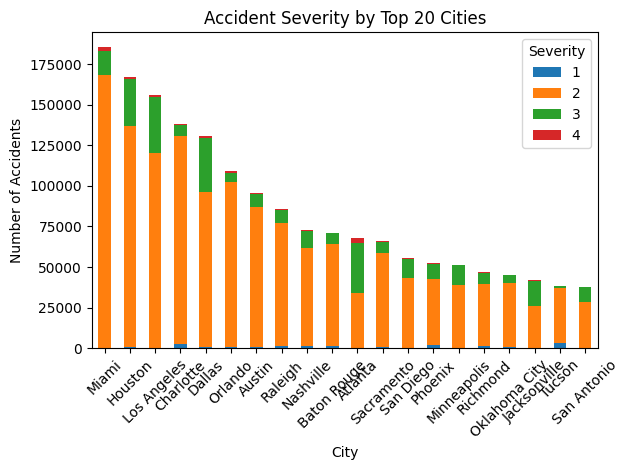

In [49]:
# Get top 20 cities by accident count
top_cities = df['City'].value_counts().head(20).index

# Filter dataframe to include only top 20 cities
df_top_cities = df[df['City'].isin(top_cities)]

# Create a crosstab for severity counts per city
severity_by_city = pd.crosstab(df_top_cities['City'], df_top_cities['Severity'])

# Sort cities by total accident count
severity_by_city = severity_by_city.loc[severity_by_city.sum(axis=1).sort_values(ascending=False).index]

# Plot stacked bar chart
plt.figure(figsize=(14, 7))
severity_by_city.plot(kind='bar', stacked=True)
plt.title('Accident Severity by Top 20 Cities')
plt.ylabel('Number of Accidents')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_5248\525110624.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data_1 = df.groupby(['Temperature_Bucket', 'Month']).size().unstack(fill_value=0)


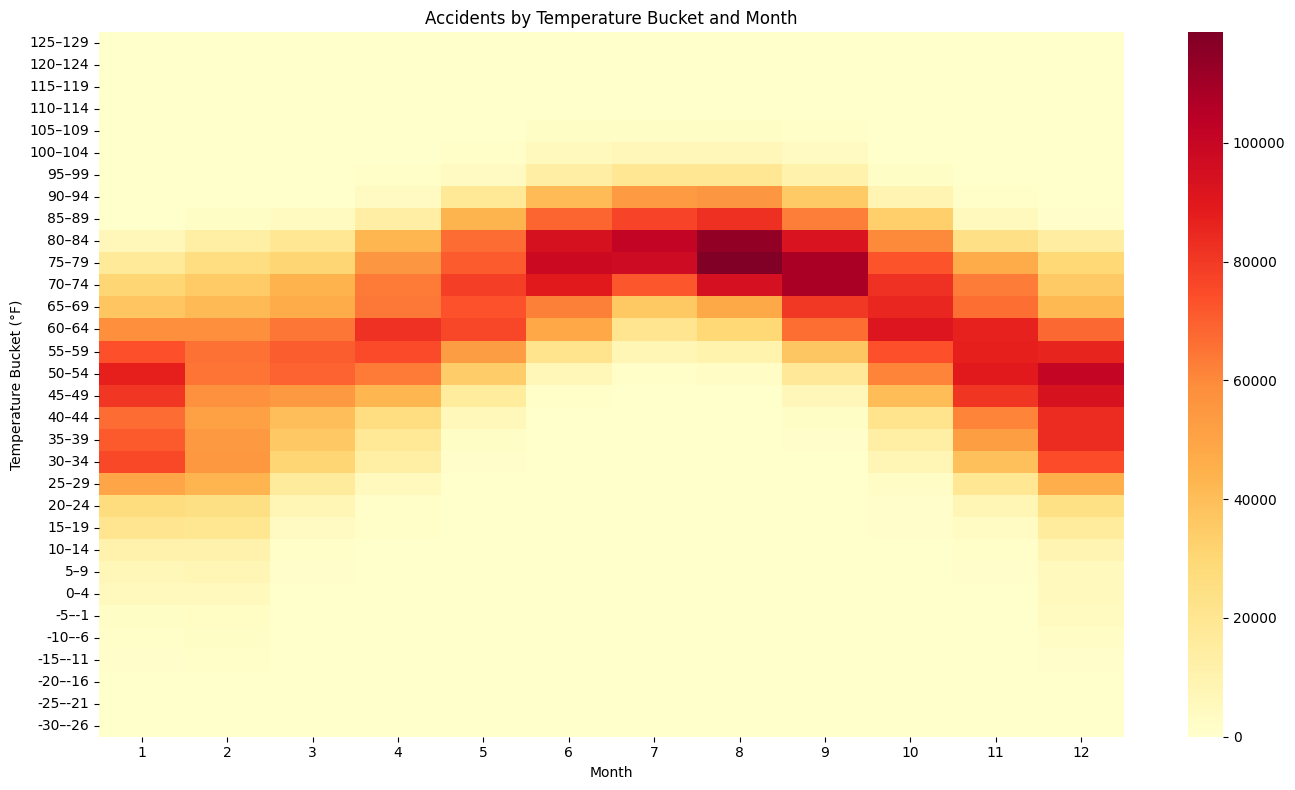

C:\Users\steve\AppData\Local\Temp\ipykernel_5248\525110624.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data_2 = df.groupby(['Region', 'Temperature_Bucket']).size().unstack(fill_value=0)


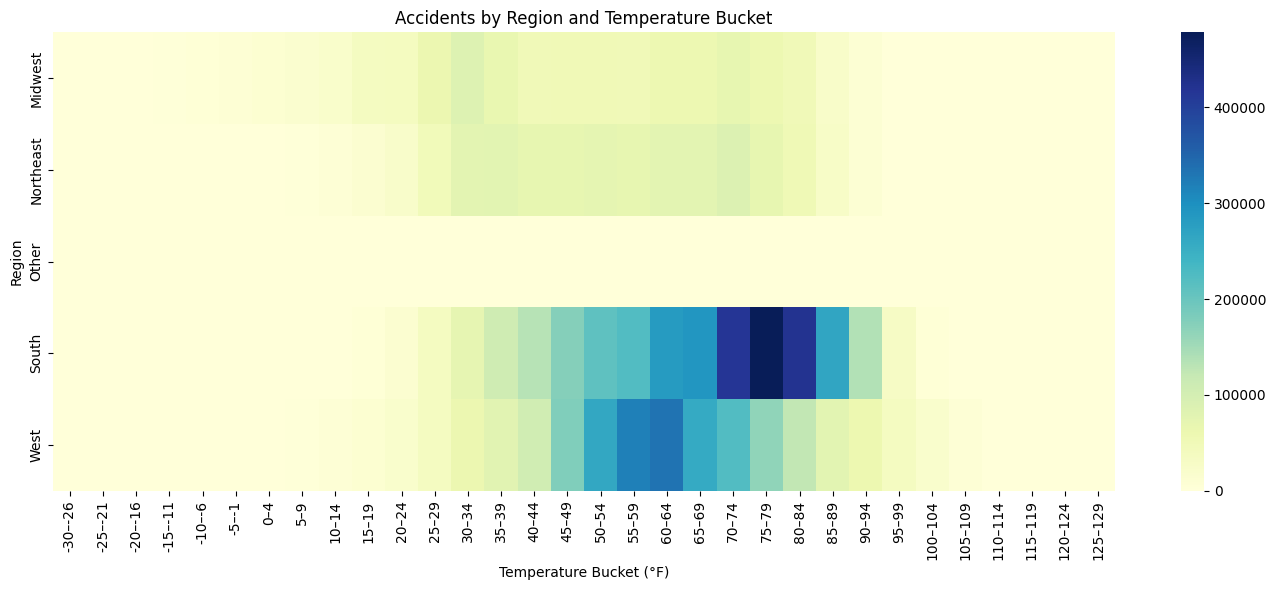

In [29]:
# Region map
region_map = {
    'South': ['TX', 'FL', 'GA', 'NC', 'SC', 'AL', 'MS', 'TN', 'KY', 'LA', 'AR', 'OK', 'VA', 'WV', 'MD', 'DE'],
    'Midwest': ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI'],
    'West': ['CA', 'WA', 'OR', 'NV', 'AZ', 'UT', 'CO', 'ID', 'MT', 'WY', 'NM'],
    'Northeast': ['NY', 'NJ', 'PA', 'CT', 'MA', 'ME', 'NH', 'RI', 'VT']
}
df['Region'] = df['State'].map(lambda x: next((region for region, states in region_map.items() if x in states), 'Other'))

# Heatmap: Accidents by Temperature Bucket and Month
heatmap_data_1 = df.groupby(['Temperature_Bucket', 'Month']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 8))
ax = sns.heatmap(heatmap_data_1, cmap="YlOrRd")
ax.invert_yaxis()
plt.title('Accidents by Temperature Bucket and Month')
plt.xlabel('Month')
plt.ylabel('Temperature Bucket (°F)')
plt.tight_layout()
plt.show()

# Heatmap: Accidents by Region and Temperature Bucket
heatmap_data_2 = df.groupby(['Region', 'Temperature_Bucket']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data_2, cmap="YlGnBu")
plt.title('Accidents by Region and Temperature Bucket')
plt.xlabel('Temperature Bucket (°F)')
plt.ylabel('Region')
plt.tight_layout()
plt.show()


**Conclusions:** These two heatmaps highlight a clear relationship between temperature, time of year, and accident frequency. The first chart shows that accidents peak during moderate to warm temperatures (55°F–80°F), especially in summer months like July and August. The second chart reveals that southern regions dominate accident counts in these same temperature ranges, reinforcing the idea that climate and region play a role in accident patterns. Together, these visuals suggest that higher accident volumes are not necessarily driven by extreme weather, but rather by the conditions most common in high-traffic regions like the South.

C:\Users\steve\AppData\Local\Temp\ipykernel_5248\1738540135.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severity_temp = df.groupby(['Temperature_Bucket', 'Severity']).size().unstack(fill_value=0)


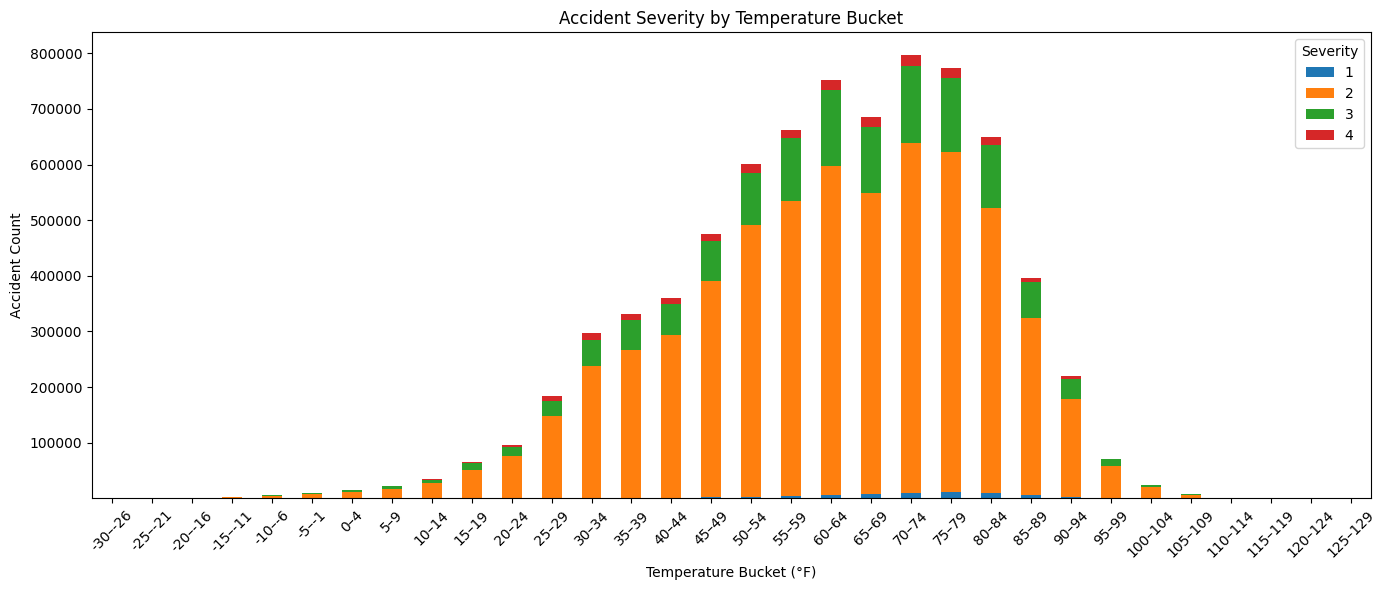

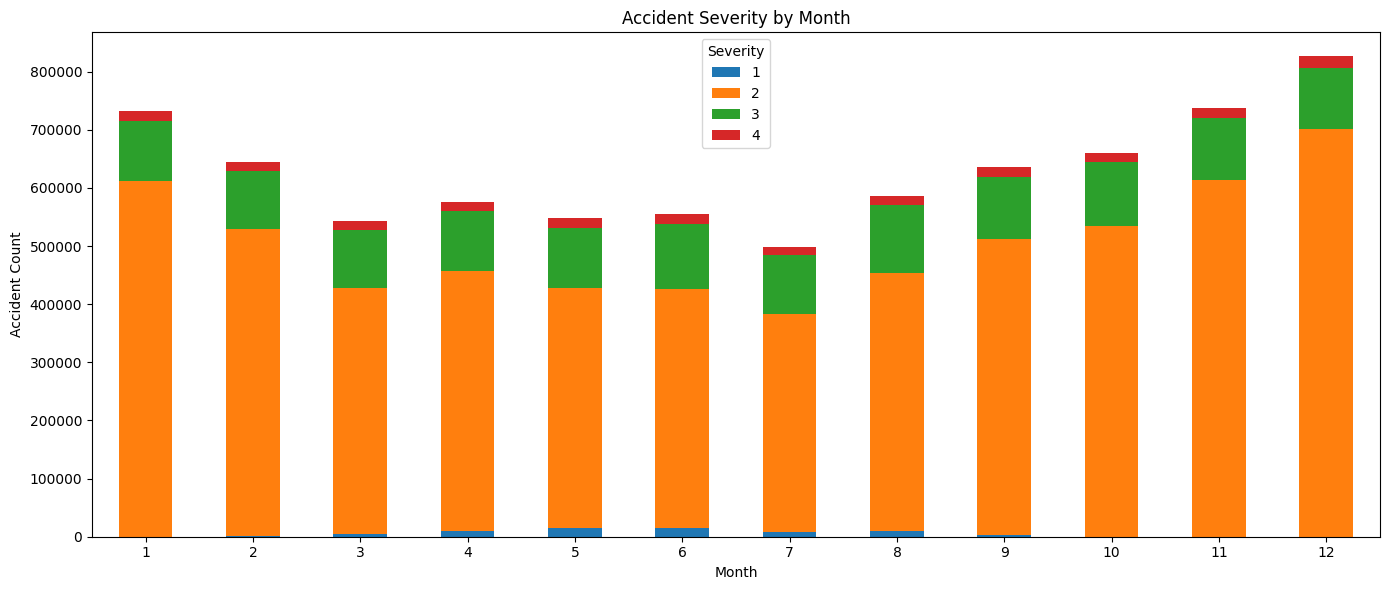

In [30]:
# Accident Severity by Temperature Bucket
severity_temp = df.groupby(['Temperature_Bucket', 'Severity']).size().unstack(fill_value=0)
severity_temp.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Accident Severity by Temperature Bucket')
plt.xlabel('Temperature Bucket (°F)')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Accident Severity by Month
severity_month = df.groupby(['Month', 'Severity']).size().unstack(fill_value=0)
severity_month.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Accident Severity by Month')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

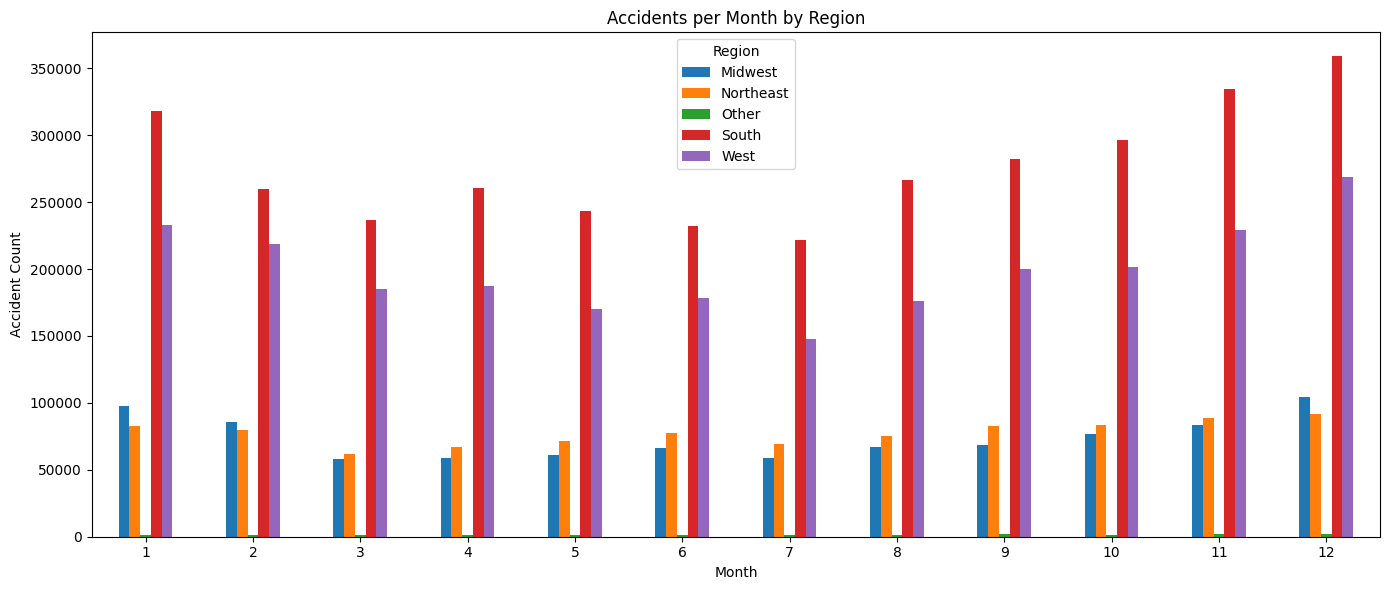

In [31]:
# Now group and plot
region_month_counts = df.groupby(['Region', 'Month']).size().unstack(fill_value=0)

region_month_counts.T.plot(kind='bar', figsize=(14, 6))
plt.title('Accidents per Month by Region')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.legend(title='Region')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

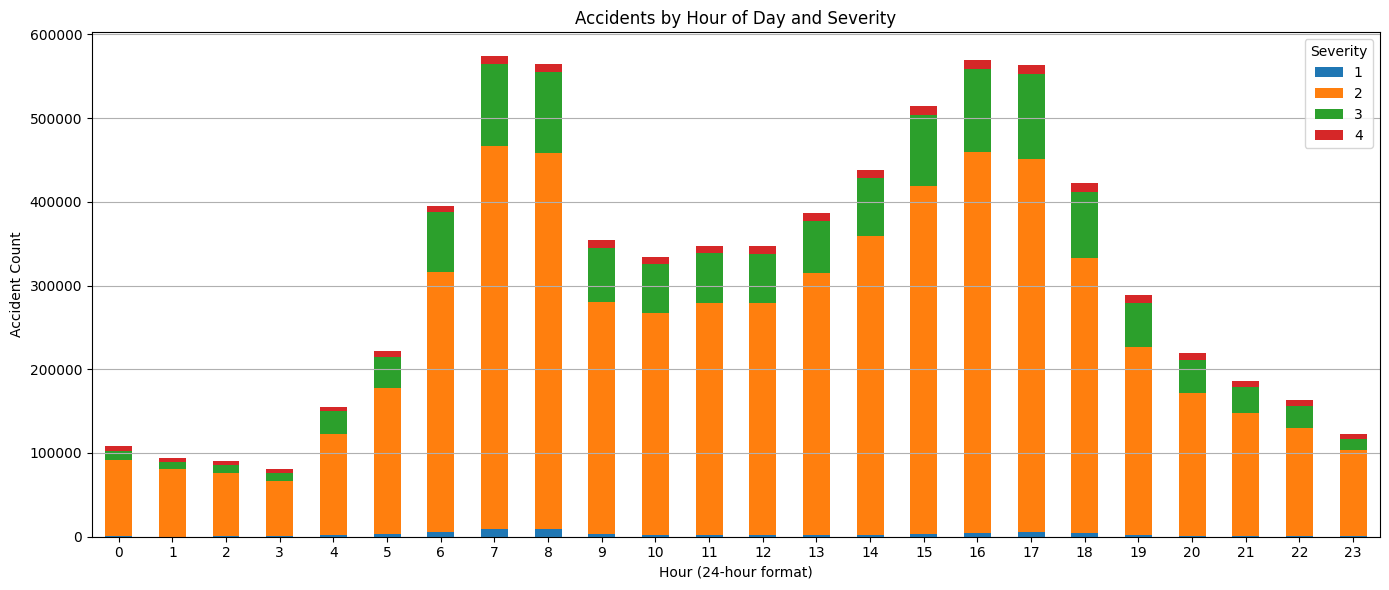

In [32]:
# Group by Hour and Severity
severity_hour = df.groupby(['Hour', 'Severity']).size().unstack(fill_value=0)

# Plot
severity_hour.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Accidents by Hour of Day and Severity')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Accident Count')
plt.xticks(rotation=0)
plt.legend(title='Severity')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

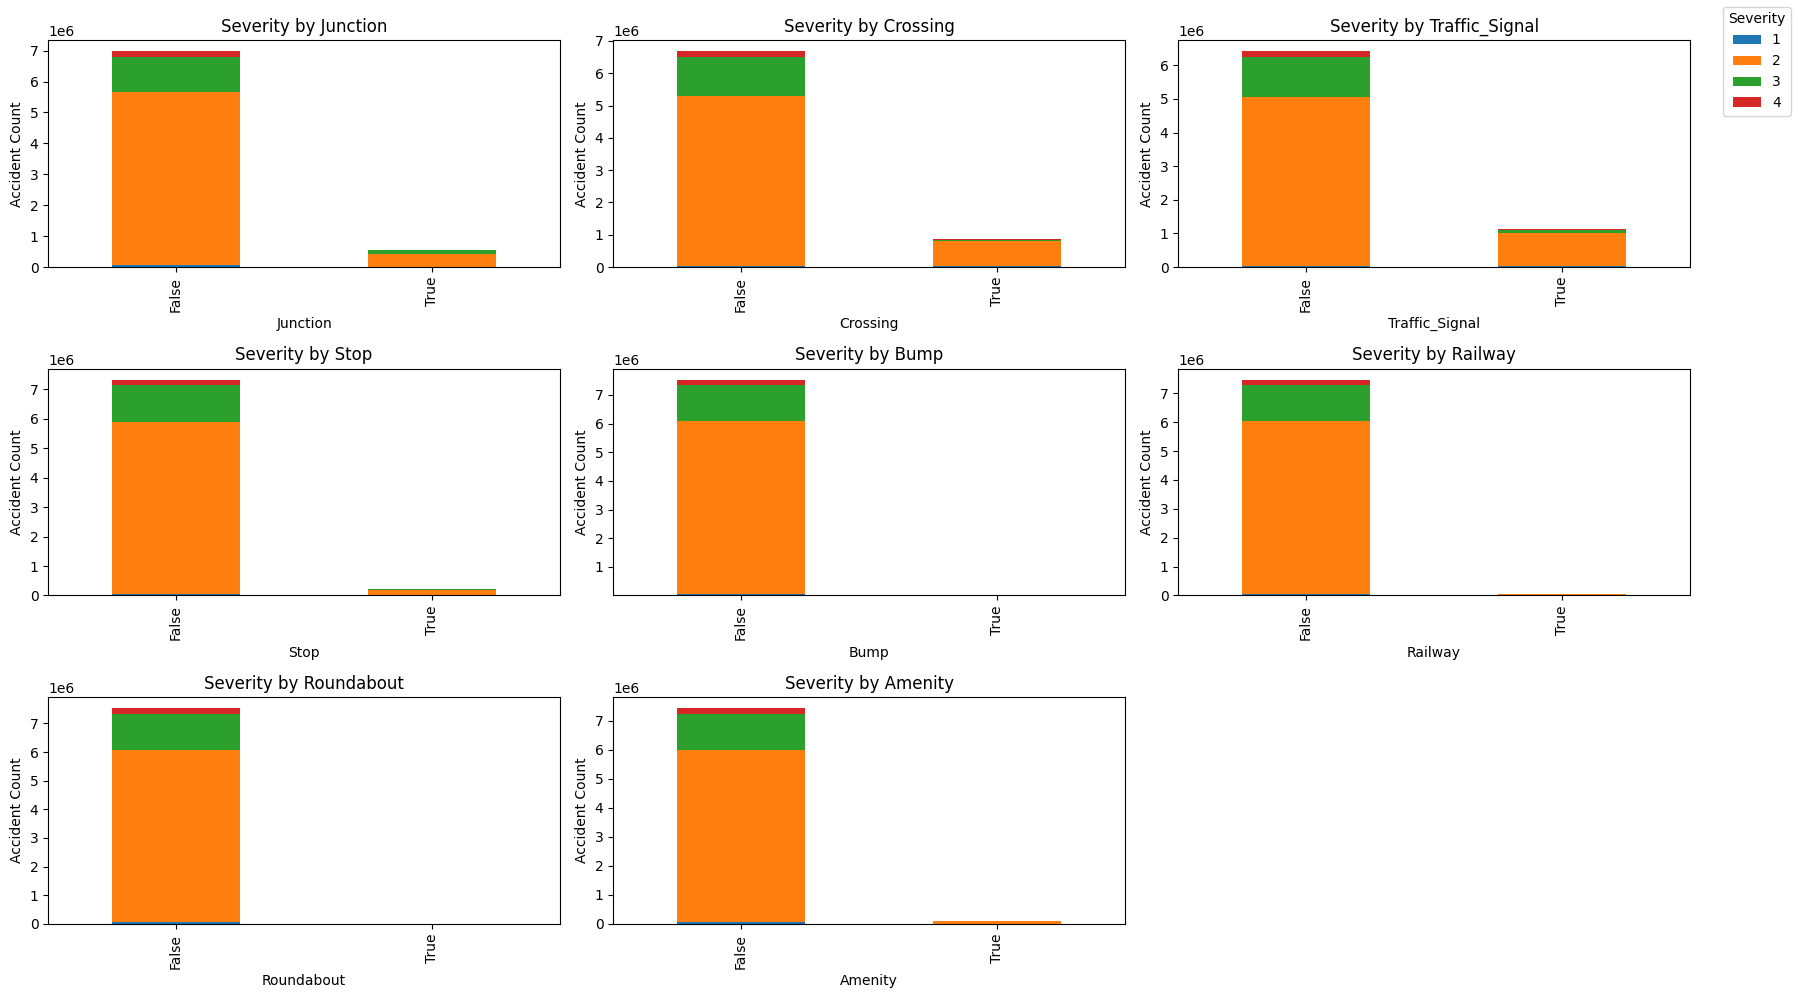

In [33]:
# List of road feature columns to analyze
road_features = [
    'Junction', 'Crossing', 'Traffic_Signal', 'Stop', 
    'Bump', 'Railway', 'Roundabout', 'Amenity'
]

n_cols = 3
n_rows = (len(road_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(road_features):
    crosstab = pd.crosstab(df[feature], df['Severity'])
    crosstab.plot(kind='bar', stacked=True, ax=axes[i], legend=False)
    axes[i].set_title(f'Severity by {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Accident Count')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Severity', loc='upper right')

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

### Statistical Data Analysis

In [35]:
from scipy.stats import chi2_contingency
import pandas as pd

def chi_square_test(df, feature, target='Severity', bins=None):
    if bins:
        binned_col = feature + '_binned'
        df[binned_col] = pd.cut(df[feature], bins=bins)
        feature_to_use = binned_col
    else:
        feature_to_use = feature

    contingency = pd.crosstab(df[feature_to_use], df[target])
    chi2, p, dof, _ = chi2_contingency(contingency)

    print(f"Feature: {feature}")
    print(f"Chi² Statistic: {chi2:.2f}")
    print(f"p-value: {p:.4e}")
    print(f"Degrees of Freedom: {dof}")
    print("Conclusion:", "Significant" if p < 0.05 else "Not significant")
    print("-" * 50)

# Binning strategies
temp_bins = list(range(-40, 140, 10))
humidity_bins = list(range(0, 110, 10))
visibility_bins = [0, 1, 3, 5, 10, 20, 100]
wind_speed_bins = [0, 5, 10, 15, 20, 30, 50, 100]
precip_bins = [0, 0.01, 0.1, 0.5, 1, 2, 5]
pressure_bins = [25, 27, 29, 30, 31, 32, 33]

# Replace with the correct column names if needed
features_to_test = [
    ('Temperature(F)', temp_bins),
    ('Humidity(%)', humidity_bins),
    ('Visibility(mi)', visibility_bins),
    ('Wind_Speed(mph)', wind_speed_bins),
    ('Precipitation(in)', precip_bins),
    ('Pressure(in)', pressure_bins)
    # ('Weather_Condition', None)  # Uncomment if correct name confirmed
]

for feature, bins in features_to_test:
    chi_square_test(df, feature, bins=bins)

Feature: Temperature(F)
Chi² Statistic: 38194.09
p-value: 0.0000e+00
Degrees of Freedom: 48
Conclusion: Significant
--------------------------------------------------
Feature: Humidity(%)
Chi² Statistic: 18025.44
p-value: 0.0000e+00
Degrees of Freedom: 27
Conclusion: Significant
--------------------------------------------------
Feature: Visibility(mi)
Chi² Statistic: 9372.81
p-value: 0.0000e+00
Degrees of Freedom: 15
Conclusion: Significant
--------------------------------------------------
Feature: Wind_Speed(mph)
Chi² Statistic: 4530.49
p-value: 0.0000e+00
Degrees of Freedom: 18
Conclusion: Significant
--------------------------------------------------
Feature: Precipitation(in)
Chi² Statistic: 1607.26
p-value: 0.0000e+00
Degrees of Freedom: 15
Conclusion: Significant
--------------------------------------------------
Feature: Pressure(in)
Chi² Statistic: 74222.86
p-value: 0.0000e+00
Degrees of Freedom: 15
Conclusion: Significant
--------------------------------------------------


In [38]:
from scipy.stats import f_oneway

# Function to run ANOVA tests
def run_anova_tests(df, numerical_features, target='Severity'):
    results = []

    for feature in numerical_features:
        df_clean = df[[feature, target]].dropna()
        groups = [group[feature].values for _, group in df_clean.groupby(target)]

        stat, p = f_oneway(*groups)

        results.append({
            'Feature': feature,
            'F-Statistic': stat,
            'p-value': p,
            'Conclusion': 'Significant' if p < 0.05 else 'Not significant'
        })

    return pd.DataFrame(results)

# Features to test
numerical_features = [
    'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
    'Wind_Speed(mph)', 'Precipitation(in)', 'Pressure(in)'
]

# Run the tests in your local environment
anova_results = run_anova_tests(df, numerical_features)
print(anova_results)

             Feature   F-Statistic        p-value   Conclusion
0     Temperature(F)   9870.222260   0.000000e+00  Significant
1        Humidity(%)   1502.029513   0.000000e+00  Significant
2     Visibility(mi)    472.015536  1.037514e-306  Significant
3    Wind_Speed(mph)   5327.162386   0.000000e+00  Significant
4  Precipitation(in)   1807.557261   0.000000e+00  Significant
5       Pressure(in)  13591.968053   0.000000e+00  Significant


In [39]:
# Define binning rules
df['Temperature(F)_binned'] = pd.cut(df['Temperature(F)'], bins=np.arange(-40, 140 + 10, 10))
df['Humidity(%)_binned'] = pd.cut(df['Humidity(%)'], bins=np.arange(0, 110 + 10, 10))
df['Visibility(mi)_binned'] = pd.cut(df['Visibility(mi)'], bins=[0, 1, 3, 5, 10, 20, 100])
df['Wind_Speed(mph)_binned'] = pd.cut(df['Wind_Speed(mph)'], bins=[0, 5, 10, 15, 20, 30, 50, 100])
df['Precipitation(in)_binned'] = pd.cut(df['Precipitation(in)'], bins=[0, 0.01, 0.1, 0.5, 1, 2, 5])
df['Pressure(in)_binned'] = pd.cut(df['Pressure(in)'], bins=[25, 27, 29, 30, 31, 32, 33])

# Cramér's V calculation function
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Evaluate each feature
features_binned = [
    'Temperature(F)_binned',
    'Humidity(%)_binned',
    'Visibility(mi)_binned',
    'Wind_Speed(mph)_binned',
    'Precipitation(in)_binned',
    'Pressure(in)_binned'
]

def interpret_cramers_v(v):
    if v < 0.05:
        return 'Negligible'
    elif v < 0.10:
        return 'Weak'
    elif v < 0.15:
        return 'Moderate'
    elif v < 0.25:
        return 'Relatively Strong'
    else:
        return 'Strong'

# Evaluate each feature
results = []
for feature in features_binned:
    contingency = pd.crosstab(df[feature], df['Severity'])
    v = cramers_v(contingency)
    interpretation = interpret_cramers_v(v)
    results.append((feature, v, interpretation))

# Create and display the DataFrame
cramers_df = pd.DataFrame(results, columns=['Feature', "Cramér's V", 'Association Strength'])
cramers_df = cramers_df.sort_values(by="Cramér's V", ascending=False)
print(cramers_df)


                    Feature  Cramér's V Association Strength
5       Pressure(in)_binned    0.057646                 Weak
0     Temperature(F)_binned    0.041087           Negligible
1        Humidity(%)_binned    0.028226           Negligible
4  Precipitation(in)_binned    0.025287           Negligible
2     Visibility(mi)_binned    0.020364           Negligible
3    Wind_Speed(mph)_binned    0.015155           Negligible


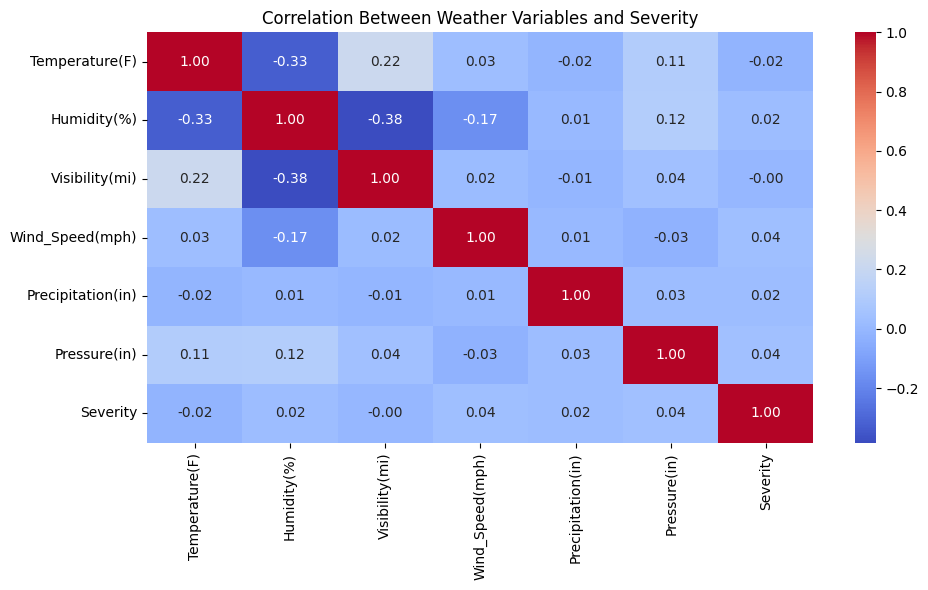

In [40]:
# 3. Correlation Matrix for Numerical Variables
num_cols = ['Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Pressure(in)', 'Severity']
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Weather Variables and Severity")
plt.tight_layout()
plt.show()

**Conclusions:** From the combined results of the Chi-Square test, ANOVA, and Cramér’s V, we can conclude that weather-related features such as temperature, humidity, visibility, wind speed, precipitation, and pressure are all statistically significant in relation to accident severity. This means that these variables are not random in how they relate to severity—they do play some role. However, their practical impact is limited: Cramér’s V values indicate that most of these associations are negligible, with only pressure showing a weak association. The correlation heatmap reinforces this, showing very low correlation values with severity. In short, while weather conditions matter and are statistically linked to accident severity, they are not strong standalone predictors.

In [ ]:
# Features to test
features = ['Junction', 'Crossing', 'Traffic_Signal', 'Stop', 'Bump', 'Railway', 'Roundabout','Amenity']

# Store results
chi_square_results = {}

for feature in features:
    # Create contingency table
    contingency_table = pd.crosstab(df[feature], df['Severity'])

    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Store results
    chi_square_results[feature] = {
        'Chi2 Statistic': chi2,
        'p-value': p,
        'Degrees of Freedom': dof
    }

# Display results with interpretation
for feature, result in chi_square_results.items():
    print(f"\nFeature: {feature}")
    print(f"Chi² Statistic: {result['Chi2 Statistic']:.2f}")
    print(f"p-value: {result['p-value']:.4e}")
    print(f"Degrees of Freedom: {result['Degrees of Freedom']}")

    if result['p-value'] < 0.05:
        print("Conclusion: There is a statistically significant association between this feature and accident severity.")
        print("This suggests that the presence or absence of", feature, "may influence the severity of accidents.")
    else:
        print("Conclusion: No statistically significant association was found.")
        print("The presence or absence of", feature, "does not appear to affect accident severity significantly.")



Feature: Junction
Chi² Statistic: 21210.41
p-value: 0.0000e+00
Degrees of Freedom: 3
Conclusion: There is a statistically significant association between this feature and accident severity.
This suggests that the presence or absence of Junction may influence the severity of accidents.

Feature: Crossing
Chi² Statistic: 111017.88
p-value: 0.0000e+00
Degrees of Freedom: 3
Conclusion: There is a statistically significant association between this feature and accident severity.
This suggests that the presence or absence of Crossing may influence the severity of accidents.

Feature: Traffic_Signal
Chi² Statistic: 111227.13
p-value: 0.0000e+00
Degrees of Freedom: 3
Conclusion: There is a statistically significant association between this feature and accident severity.
This suggests that the presence or absence of Traffic_Signal may influence the severity of accidents.

Feature: Stop
Chi² Statistic: 27075.49
p-value: 0.0000e+00
Degrees of Freedom: 3
Conclusion: There is a statistically signif

In [43]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Define interpretation of strength
def interpret_strength(v):
    if v < 0.05:
        return 'Negligible'
    elif v < 0.10:
        return 'Weak'
    elif v < 0.15:
        return 'Moderate'
    elif v < 0.25:
        return 'Relatively Strong'
    else:
        return 'Strong'

cramers_results = {}

for feature in features:
    contingency = pd.crosstab(df[feature], df['Severity'])
    cramer_v = cramers_v(contingency)
    cramers_results[feature] = cramer_v

# Create DataFrame
cramers_results_df = pd.DataFrame(
    list(cramers_results.items()),
    columns=['Feature', "Cramér's V"]
)

# Add interpretation column
cramers_results_df['Association Strength'] = cramers_results_df["Cramér's V"].apply(interpret_strength)

# Sort and display
cramers_results_df = cramers_results_df.sort_values(by="Cramér's V", ascending=False)

print(cramers_results_df)

          Feature  Cramér's V Association Strength
2  Traffic_Signal    0.121442             Moderate
1        Crossing    0.121328             Moderate
3            Stop    0.059917                 Weak
0        Junction    0.053032                 Weak
7         Amenity    0.038700           Negligible
5         Railway    0.013547           Negligible
4            Bump    0.005323           Negligible
6      Roundabout    0.002334           Negligible


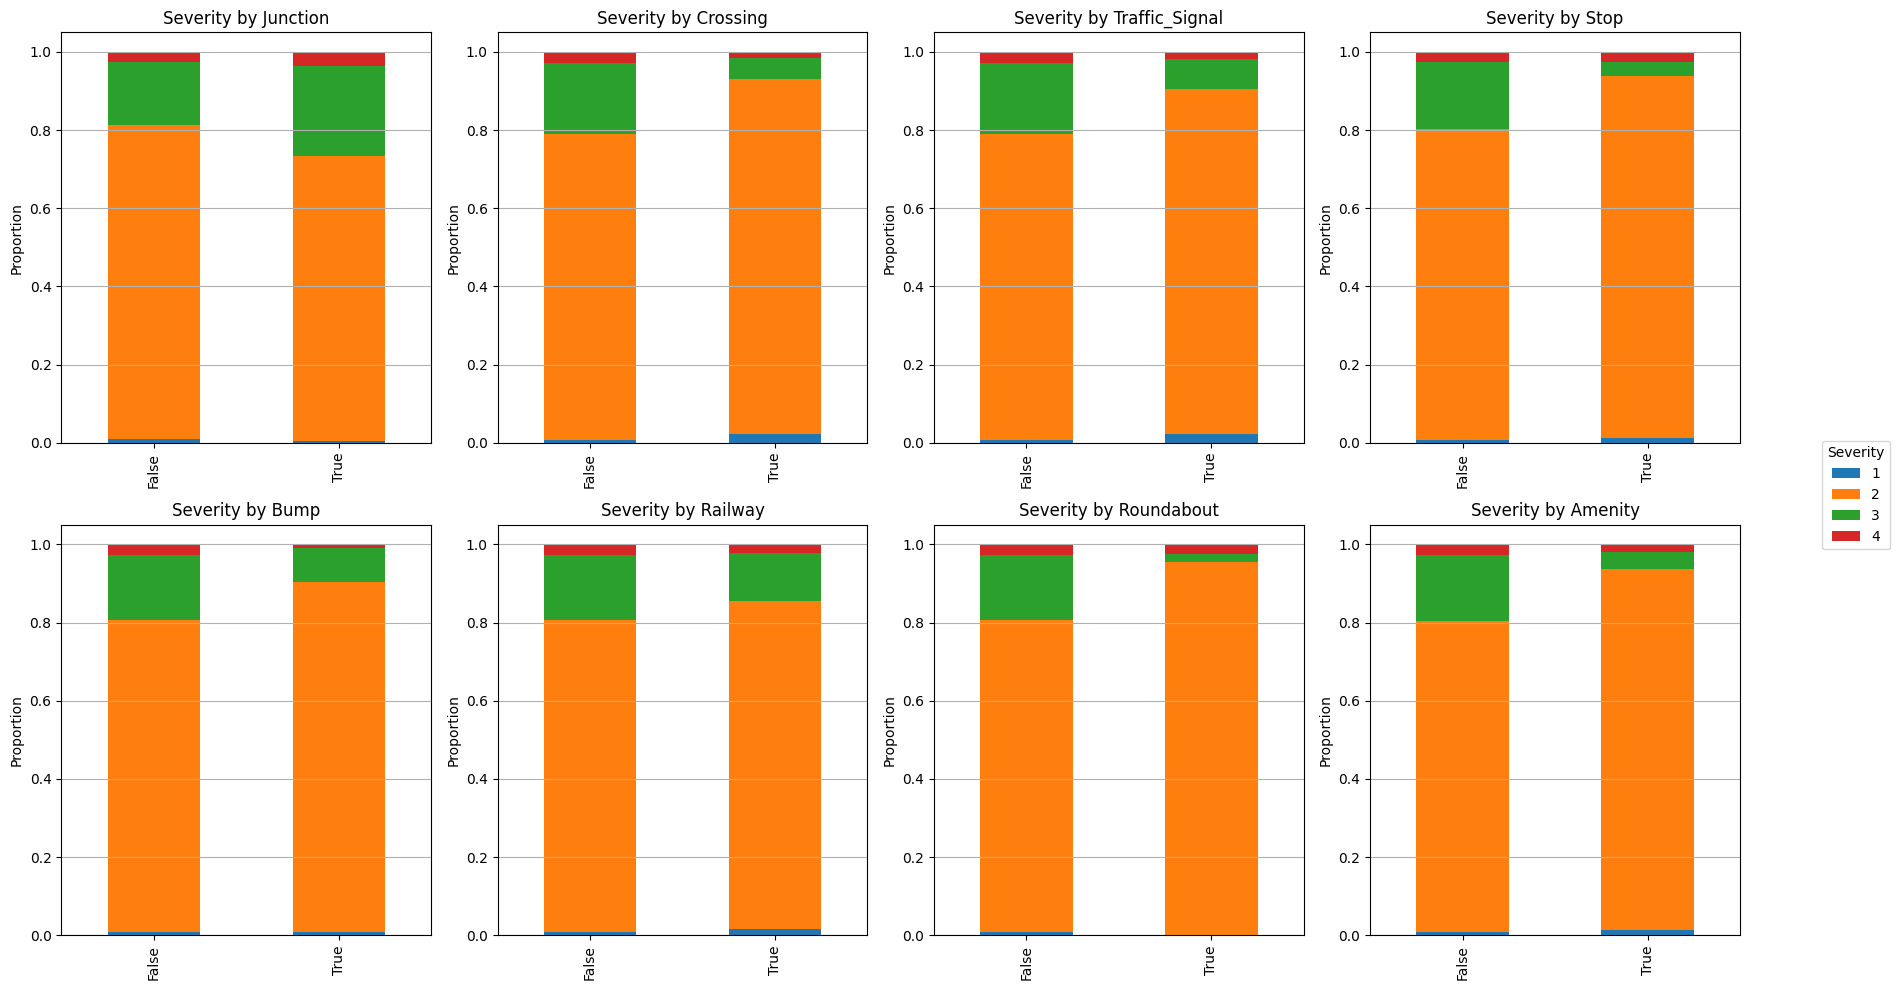

In [44]:
# List of features to plot
features = [
    'Junction', 'Crossing', 'Traffic_Signal', 'Stop', 
    'Bump', 'Railway', 'Roundabout', 'Amenity'
]

# Setup the grid layout
n_cols = 4
n_rows = (len(features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

# Generate the plots
for i, feature in enumerate(features):
    ax = axes[i]
    severity_dist = (
        df.groupby([feature, 'Severity'])
        .size()
        .unstack()
        .div(df.groupby(feature).size(), axis=0)
    )
    severity_dist.plot(kind='bar', stacked=True, ax=ax, legend=False)
    ax.set_title(f'Severity by {feature}')
    ax.set_xlabel('')
    ax.set_ylabel('Proportion')
    ax.grid(axis='y')

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Place one legend outside the grid
fig.tight_layout(rect=[0, 0, 0.88, 1])
fig.legend(title='Severity', labels=[1, 2, 3, 4], loc='center left', bbox_to_anchor=(0.91, 0.5))
plt.show()


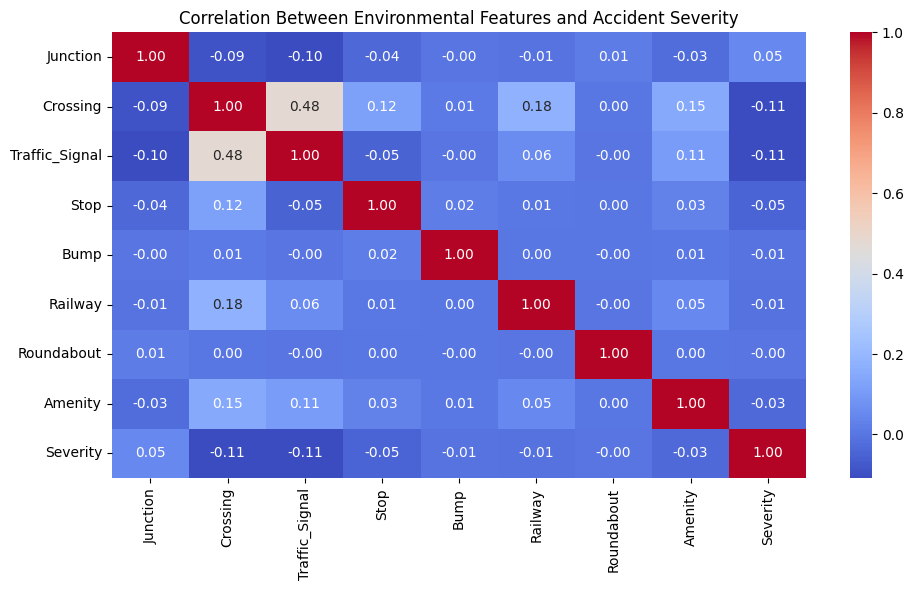

In [55]:
features = [
    'Junction', 'Crossing', 'Traffic_Signal', 'Stop', 
    'Bump', 'Railway', 'Roundabout', 'Amenity','Severity'
]
# Compute correlation matrix
env_corr = df[features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(env_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Environmental Features and Accident Severity")
plt.tight_layout()
plt.show()

**Conclusions:** The combined statistical tests and visualizations confirm that several environmental features are significantly associated with accident severity, but their practical impact varies. Traffic signals and pedestrian crossings show a moderate strength of association (Cramér’s V ≈ 0.12), suggesting that intersections and areas with pedestrian activity are key zones for accident severity intervention. Features like stops and junctions have a weaker yet still notable effect, while others, such as bumps, railways, roundabouts, and amenities, demonstrate negligible associations. This is likely due to their relatively low occurrence in the dataset, which limits their statistical influence despite being significant. The correlation matrix reinforces this, showing only very weak correlations between environmental features and severity. Overall, traffic-control infrastructure, especially signals and crossings, should be prioritized when planning safety improvements.

## Evaluation

### Business Insight/Recommendation 1

One key recommendation from this analysis is to prioritize safety interventions at traffic-control infrastructure, particularly at traffic signals and pedestrian crossings. These features demonstrated a moderate association with accident severity, with a Cramér’s V value of approximately 0.12. The data also revealed that roads with traffic signals and crossings experience a disproportionately higher number of Severity 2 accidents. To address this, improvements should be made to the visibility of these areas, as well as to signal timing and signage.

### Business Insight/Recommendation 2

Another important recommendation is to monitor and adjust for air pressure conditions, as air pressure showed the highest association with accident severity among weather-related features. Although the Cramér’s V value for pressure was 0.057: classified as weak, it was still stronger than that of other environmental variables. The analysis suggests that sudden drops in air pressure, which may indicate stormy or unstable weather, could be linked to increased accident severity. To mitigate this risk, transportation systems could incorporate real-time weather monitoring to trigger dynamic speed limits or driver alerts, particularly on highways where high-speed accidents can be more severe.

### Business Insight/Recommendation 3

One final recommendation is to focus on improving road safety during high-risk months and in regions with consistently elevated accident rates. The data shows that accident volumes peak during the winter months, particularly in December and January, while Southern states like Florida, Texas, and Georgia experience higher accident counts throughout the year. Interestingly, these increases occur even though winter temperatures in the South tend to be mild. This suggests that factors such as heavier holiday travel, shorter daylight hours, and fluctuating weather conditions, rather than extreme cold may be contributing to the seasonal spike in accidents.

To mitigate these risks, targeted safety messaging should be developed specifically for Southern regions during the winter months, emphasizing alert driving, safe trip planning, and awareness of changing road conditions. Public awareness campaigns in the lead-up to the holidays can help prepare drivers for increased traffic. Law enforcement visibility should be heightened during high-travel periods, and infrastructure improvements like better lighting and clearer signage can reduce risk at accident-prone locations. Real-time alerts about weather and traffic hazards can also support safer decision-making. By aligning safety strategies with these seasonal and geographic patterns, transportation authorities can more effectively reduce accident frequency and severity.

### Tableau Dashboard link
https://public.tableau.com/app/profile/steven.liao/viz/Traffic_Accidents/Dashboard1?publish=yes

## Conclusion and Next Steps

Conclusions

This analysis reveals that traffic-control infrastructure, particularly features like traffic signals and pedestrian crossings, has a measurable impact on accident severity. Enhancing visibility, adjusting signal timing, and improving design at these locations could help reduce how severe accidents are. Environmental factors such as temperature, air pressure, and visibility, while statistically significant, show only weak associations with severity. However, they can still be useful for proactive safety monitoring. Seasonal and regional trends appear to be stronger predictors of accident frequency, with southern states and winter months consistently reporting higher volumes—likely due to increased travel, changes in daylight, and holiday activity rather than extreme weather.

Next Steps

Future efforts should prioritize improving infrastructure at high-risk intersections, using historical accident data to guide decisions. Integrating real-time weather and traffic information into safety systems could enable dynamic responses, such as speed limit adjustments or driver alerts during hazardous conditions. Seasonal safety campaigns, especially in southern regions, should focus on distracted driving and holiday-related risks. Lastly, expanding the dataset to include traffic volume, population density, or road condition reports would allow for more advanced predictive models and deeper insights into accident patterns.